In [64]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer, SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid
from sklearn.decomposition import PCA


#import knn classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestClassifier
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error,  mean_squared_error, r2_score, accuracy_score

# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras import regularizers
# from keras import initializers
# from keras.layers import BatchNormalization
# from tensorflow.keras.constraints import MaxNorm
# from kerastuner.tuners import Hyperband

# from tensorflow.keras.optimizers import Adam

# import shap
# from lime import lime_tabular


In [65]:
train = pd.read_csv('data/train.csv')
train_extra = pd.read_csv('data/training_extra.csv')
test = pd.read_csv('data/test.csv')
train_noisy = pd.read_csv('data/Noisy_Student_Bag_Price_Prediction_Dataset.csv')


In [66]:
train = pd.concat([train, train_extra], axis=0)
train.reset_index(inplace=True, drop=True)
train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


### NaN Treatment

In [67]:
train.columns

Index(['id', 'Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price'],
      dtype='object')

In [68]:
print(train.isna().sum().sum())

cat_cols = [col for col in train.columns if train[col].dtype not in ['float64', 'int64']]

train[cat_cols] = train[cat_cols].fillna('Unknown')
test[cat_cols] = test[cat_cols].fillna('Unknown')


print(train.isna().sum().sum())

757967
1808


In [69]:
# impute weight capacity
train.fillna({'Weight Capacity (kg)': train['Weight Capacity (kg)'].mean()}, inplace=True)

### Merge Extra set

In [70]:
train_noisy = train_noisy.loc[(train_noisy["Weight Capacity (kg)"]>5)&(train_noisy["Weight Capacity (kg)"]<30)]
train_noisy.columns = [f"orig_{c}" for c in train_noisy.columns]
train = train.merge(train_noisy, left_on="Weight Capacity (kg)", right_on="orig_Weight Capacity (kg)", how="left")
train = train.drop("id",axis=1)
test = test.merge(train_noisy, left_on="Weight Capacity (kg)", right_on="orig_Weight Capacity (kg)", how="left")
train.head()


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,orig_Brand,orig_Material,orig_Size,orig_Compartments,orig_Laptop Compartment,orig_Waterproof,orig_Style,orig_Color,orig_Weight Capacity (kg),orig_Price
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875,Puma,Nylon,Small,7.0,No,Yes,Tote,Black,11.611723,39.770555
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Add target encoded feature with k folds

In [71]:
te_cols = ["Weight Capacity (kg)"]

new_feature_cols = [feature + '_te' for feature in te_cols]

In [72]:

# Initialize KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for col in te_cols:
    print(col)
    # Create a new column to store the encoded values
    train[col + '_te'] = np.nan

    # Out-of-fold target encoding
    for train_idx, val_idx in kf.split(train):
        # Split data
        train_set, val_set = train.iloc[train_idx], train.iloc[val_idx]
        
        # Calculate category means on training data
        category_means = train_set.groupby(col)['Price'].mean()
        
        # Encode validation fold using category means from the training fold
        train.loc[val_idx, col + '_te'] = train.loc[val_idx, col].map(category_means)

    # Fill any NaN values with the overall mean target
    overall_mean = train[col].mean()
    
    train.fillna({col + '_te':overall_mean}, inplace=True)  # Fill any NaN values with the overall mean target 

    final_category_means = train.groupby(col)['Price'].mean()

    # Map the test set categories using the train set means
    test[col + '_te'] = test[col].map(final_category_means)

    # Fill NaN values in the test set with the overall mean
    test.fillna({col + '_te':overall_mean}, inplace=True)

Weight Capacity (kg)


### Training

In [73]:
CATS = []
for c in train.columns:
    if train[c].dtype=='object':
        CATS.append(c)
print(f"There are {len(CATS)} categorical columns:")
print( CATS )
NUMS = ['Weight Capacity (kg)','Weight Capacity (kg)_te','orig_Price']
print(f"There are {len(NUMS)} numerical columns:")
print( NUMS )
FEATURES = CATS + NUMS

There are 14 categorical columns:
['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'orig_Brand', 'orig_Material', 'orig_Size', 'orig_Laptop Compartment', 'orig_Waterproof', 'orig_Style', 'orig_Color']
There are 3 numerical columns:
['Weight Capacity (kg)', 'Weight Capacity (kg)_te', 'orig_Price']


In [75]:
%%time

FOLDS = 7
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros((len(train)))
pred = np.zeros((len(test)))

# OUTER K FOLD
for i, (train_index, test_index) in enumerate(kf.split(train)):
    print(f"### Fold {i+1} ###")

    X_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,'Price']

    X_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,'Price']

    X_test = test[FEATURES].copy()

    # CONVERT TO CATS SO XGBOOST RECOGNIZES THEM
    X_train[CATS] = X_train[CATS].astype("category")
    X_valid[CATS] = X_valid[CATS].astype("category")
    X_test[CATS] = X_test[CATS].astype("category")

    # BUILD MODEL
    model = xgb.XGBRegressor(
        max_depth=6,  
        colsample_bytree=0.5, 
        subsample=0.8,  
        n_estimators=10_000,  
        learning_rate=0.2,  
        enable_categorical=True,
        min_child_weight=10,
        early_stopping_rounds=100,
    )
    
    # TRAIN MODEL
    COLS = X_train.columns
    model.fit(
        X_train[COLS], y_train,
        eval_set=[(X_valid[COLS], y_valid)],  
        verbose=100,
    )

    # PREDICT OOF AND TEST
    oof[test_index] = model.predict(X_valid[COLS])
    pred += model.predict(X_test[COLS])

pred /= FOLDS

### Fold 1 ###
[0]	validation_0-rmse:38.90370
[100]	validation_0-rmse:38.65669
[186]	validation_0-rmse:38.65760
### Fold 2 ###
[0]	validation_0-rmse:38.89989
[100]	validation_0-rmse:38.65822
[200]	validation_0-rmse:38.65883
[266]	validation_0-rmse:38.66099
### Fold 3 ###
[0]	validation_0-rmse:38.91978
[100]	validation_0-rmse:38.66637
[200]	validation_0-rmse:38.66767
[214]	validation_0-rmse:38.66893
### Fold 4 ###
[0]	validation_0-rmse:38.96026
[100]	validation_0-rmse:38.71441
[188]	validation_0-rmse:38.71692
### Fold 5 ###
[0]	validation_0-rmse:38.95661
[100]	validation_0-rmse:38.70971
[200]	validation_0-rmse:38.71034
[246]	validation_0-rmse:38.71102
### Fold 6 ###
[0]	validation_0-rmse:38.89861
[100]	validation_0-rmse:38.64984
[185]	validation_0-rmse:38.65054
### Fold 7 ###
[0]	validation_0-rmse:38.99412
[100]	validation_0-rmse:38.74282
[189]	validation_0-rmse:38.74496
CPU times: user 19min 58s, sys: 25.8 s, total: 20min 24s
Wall time: 4min 41s


### Overall CV

In [76]:
# COMPUTE OVERALL CV SCORE
true = train.Price.values
s = np.sqrt(np.mean( (oof-true)**2.0 ) )
print(f"=> Overall CV Score = {s}")


=> Overall CV Score = 38.68480767692945


### Feature Importance

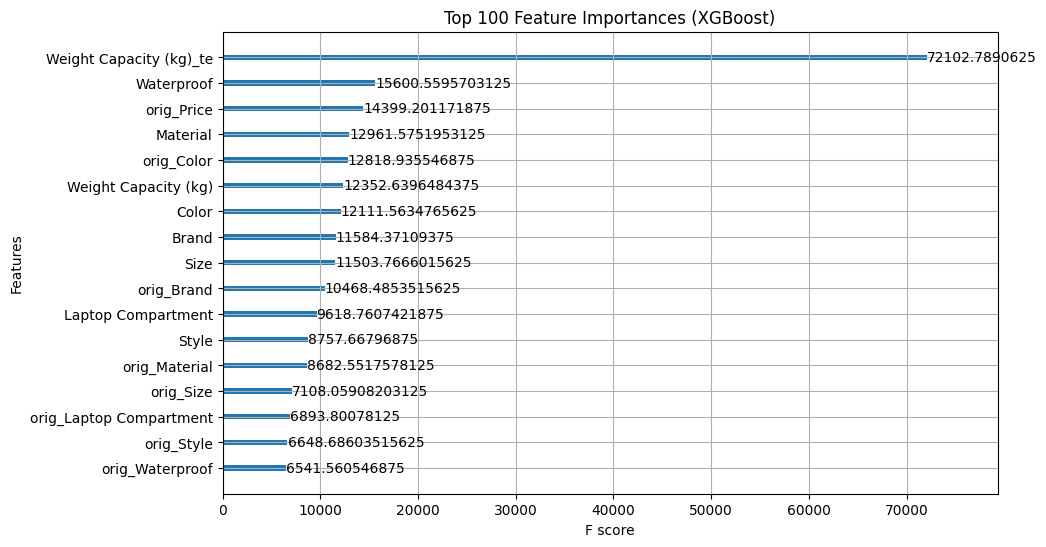

In [77]:
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=100, importance_type='gain',ax=ax)
plt.title("Top 100 Feature Importances (XGBoost)")
plt.show()

In [79]:
sub = pd.read_csv("./data/sample_submission.csv")
sub.Price = pred
sub.to_csv(f"submission.csv",index=False)
sub.head()

,id,Price
0,300000,80.854758
1,300001,81.918771
2,300002,88.632773
3,300003,79.567390
4,300004,79.130877
